# Word 2 Vec

The following notebook walks you through using word2vec from the Python Gensim package. Word2Vec is a Word Embedding Model (WEM) and helps to find how specific words are used in a given text. 

###  Before we begin
Before we start, you will need to have set up a [Carbonate account](https://kb.iu.edu/d/aolp) in order to access [Research Desktop (RED)](https://kb.iu.edu/d/apum). You will also need to have access to RED through the [thinlinc client](https://kb.iu.edu/d/aput). If you have not done any of this, or have only done some of this, but not all, you should go to our [textPrep-Py.ipynb](https://github.com/cyberdh/Text-Analysis/blob/master/Python/Py_notebooks/textPrep-Py.ipynb) before you proceed further. The textPrepPy notebook provides information and resources on how to get a Carbonate account, how to set up RED, and how to get started using the Jupyter Notebook on RED. 

### Include necessary packages for notebook 

Python's extensibility comes in large part from packages. Packages are groups of functions, data, and algorithms that allow users to easily carry out processes without recreating the wheel. Some packages are included in the basic installation of Python, others created by Python users are available for download. Make sure to have the following packages installed before beginning so that they can be accessed while running the scripts.

In your terminal, packages can be installed by simply typing "pip install nameofpackage --user" (minus the quotes).

- **sys:** Provides access to some variables used or maintained by the interpreter and to functions that interact strongly with the interpreter. It is always available.
- **re:** Provides regular expression matching operations similar to those found in Perl.
- **os:** Provides a portable way of using operating system dependent functionality.
- **string:** Contains a number of functions to process standard Python strings.
- **nltk:** A leading platform for building Python programs to work with human language data.
- **glob:** Finds all the pathnames matching a specified pattern according to the rules used by the Unix shell.
- **numpy:** a general-purpose array-processing package designed to efficiently manipulate large multi-dimensional arrays of arbitrary records without sacrificing too much speed for small multi-dimensional arrays. 
- **pandas:** An open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.
- **warnings:** Allows for the manipulation of warning messages in Python.
- **pprint:** Provides a capability to “pretty-print” arbitrary Python data structures in a form which can be used as input to the interpreter.
- **spacy:** A library for advanced Natural Language Processing in Python and Cython.
- **gensim:** Python library for topic modelling, document indexing and similarity retrieval with large corpora.


In [91]:
import sys
import re
import os
from os.path import join, isfile, splitext
import string
import nltk
from nltk.corpus import stopwords
import glob
import numpy as np
import pandas as pd
import warnings
from pprint import pprint
import spacy
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import gensim
import gensim.corpora as corpora
import gensim.downloader as api
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import doc2vec

The code in the cell below points to a module specificaly for use with the Python Jupyter Notebooks created by Cyberinfrastructure for Digital Humanities. It allows for the use of the different pakcages in our notebooks and their subsequent data sets.

#### NOTE: This cell is only for use with Research Desktop. You will get an error if you try to run this cell on your personal device!!

In [88]:
sys.path.insert(0,"/N/soft/rhel7/anaconda/environments/DigHumWkshp/lib/python3.6/site-packages")
os.environ["NLTK_DATA"] = "/N/soft/rhel7/anaconda/environments/DigHumWkshp/nltk_data"

This will ignore deprecation, user, and future warnings. All the warnings in this code are not concerning and will not break the code or cause errors in the results.

In [89]:
warnings.filterwarnings("ignore", category=UserWarning,
                        module = "gensim", lineno = 598)

warnings.filterwarnings("ignore", category=FutureWarning,
                        module = "gensim", lineno = 737)
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Getting your data

#### Directory where the data is stored
We simply list out the path to the directory where we can access the files or file we need. Note that we do not use any file names yet, just the path to the folder. This is because we may want to read in all the files in the directory, or just one. There are options below for doing both. We save the path as a variable named dataHome. Then we save a filepath that points to where we want any results saved. Again, there is no filename, just the path. We will add the name later. Lastly, we have a filepath pointing to a stopword list we have created ourselves. It is commented out at the moment, but if you wish to use your own stopword list, remove the '#' from the beginning of the last line.

In [90]:
homePath = os.environ["HOME"]
dataHome = os.path.join(homePath,"IntroDocSimilarity","data")
dataResults = os.path.join(homePath,"IntroDocSimilarity","Results")

In [ ]:
fileType = ".txt"
docLevel = True
customStop = True
docs = []
tweets = []

### Stopwords
Here we save the nltk stopwords list as the variable 'stop_words' (minus the quotes). If you need a different language, simply change 'english' (keep the quotes) to the anglicized name of the language you wish to use (e.g. 'spanish' instead of 'espanol' or 'german' instead of 'deutsch'). If you wish to add additional words to the stop_words variable, add the word in quotes to the list in stop_words.extend(['the', 'words', 'you', 'want', 'to', 'add']). 

If you wish to add a stopword list you created ahead of time and have saved as a .txt file, then remove the '#' from in front of 'with open', 'stopWordsList = ', and 'stop_words.extend(stopWordsList)'. If you need to add additional words, add them to the list of words that was mentioned in the first paragraph.

If you wish to see the list of available languages in the nltk package simply remove the '#' from the beginning of the last line in the cell.

In [93]:
# NLTK Stop words
stopWords = []
stopWords.extend(stopwords.words('english'))

stopWords.extend(['would', 'said', 'says', 'also'])

#print(" ".join(stopwords.fileids()))

#### Add own stopword list

Here you can add your own custom stopword list. Remove all of the "#" from in front of the lines then make sure that the folders and file names for "stopWordsFilepath" match the folders and file name of your stopword document.

In [95]:
stopWordsFilepath = os.path.join(homePath, "IntroDocSimilarity", "data", "earlyModernStopword.txt")

with open(stopWordsFilepath, "r",encoding = 'utf-8') as f:
    stopWordsList = [x.strip() for x in f.readlines()]

stopWords.extend(stopWordsList)

### Reading in .txt files
The code below reads in text files. It can do this in two ways. We can read in an entire directory, or we can read in a single file. Remember, LDA generally works best on larger datasets, so if you are uisng a single file it should be a large file. In order to choose between an entire directory or a single file, look at the line of code that starts "for path in glob.glob" (minus the quotes). Towards the end of the line where there is something in quotes that ends in .txt is where you switch between the entire directory or a single file. To read in the entire directory simply put "\*.txt" (this time with the quotes) and this will read all files that end in .txt. To read in a single file replace the "\*" with the file name of the file you are interested in like "myDataSet.txt". 

The below code also lets you choose between reading your data in a file at a time or line by line. You can make this choice whether you are reading in an entire directory or a single file. However, your research and data will determine whether line by line or file by file is best. In order to choose which one you need the part of the code you need to change is where it says "with open(textFilepath, "r") as f:" (minus the quotes). The part following this is where the change is made. To read in the data by file in the folder make sure the lines that say "for line in f:" and then "docs.append(f.readline())" have a "#" in front of them as this comments them out and tells Python to ignore these lines. The line we want Python to read in order to read the data in by file is "docs.append(f.read().splitlines())" (again, minus the quotes). Now to read in the data a line at a time and group the data by line instead of by file simply remove the "#" from in front of the "for line in f:" and the "docs.append(f.readline())" and put a "#" in front of "docs.append(f.read().splitlines())". This will now consider each line, regardless of which file it came from, as it's own data element.

In [96]:
docs = []
paths = glob.glob(os.path.join(dataHome, "Shakespeare","*.txt"))
for path in paths:
    with open(path, "r", encoding = 'utf-8') as file:
         # skip hidden file
        if path.startswith('.'):
            continue
        #for line in file:
        #docs.append(file.readline())
        docs.append(file.read().splitlines())

    #print('Finished tokenizing text {}\n'.format(path))

### Data variable

Now we need to change our variable containing our data to the variable "data" since this is the variable used going forward.

The last line simply prints out the first chunk of data in our collection. This can be a whole text file or single line depending on your previous choices.

In [97]:
data = docs

pprint(data[:1])

[['',
  '',
  '',
  '',
  '',
  '',
  ' In Troy there lies the scene. From isles of Greece',
  ' The princes orgulous, their high blood chafed,',
  ' Have to the port of Athens sent their ships',
  ' Fraught with the ministers and instruments',
  ' Of cruel war. Sixty and nine, that wore',
  ' Their crownets regal, from the Athenian bay',
  ' Put forth toward Phrygia, and their vow is made',
  ' To ransack Troy, within whose strong immures',
  ' The ravished Helen, Menelaus queen,',
  " With wanton Paris sleeps; and that's the quarrel.",
  ' To Tenedos they come,',
  ' And the deep-drawing barks do there disgorge',
  ' Their warlike freightage. Now on Dardan plains',
  ' The fresh and yet unbruised Greeks do pitch',
  " Their brave pavilions. Priam's six-gated city --",
  ' Dardan and Timbria, Helias, Chetas, Troien,',
  ' And Antenorides -- with massy staples',
  ' And corresponsive and fulfilling bolts,',
  ' Spar up the sons of Troy.',
  ' Now expectation, tickling skittish spirits'

### Tokenizing

This block of code separates each chunk of text in a list of individual words. In the process it also lower cases all the words and removes punctuation. If you wish to keep the punctuation change "deacc = True" to "deacc = False".

In [98]:
def sentToWords(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

dataWords = list(sentToWords(data))

print(dataWords[:1])

[['in', 'troy', 'there', 'lies', 'the', 'scene', 'from', 'isles', 'of', 'greece', 'the', 'princes', 'orgulous', 'their', 'high', 'blood', 'chafed', 'have', 'to', 'the', 'port', 'of', 'athens', 'sent', 'their', 'ships', 'fraught', 'with', 'the', 'ministers', 'and', 'instruments', 'of', 'cruel', 'war', 'sixty', 'and', 'nine', 'that', 'wore', 'their', 'crownets', 'regal', 'from', 'the', 'athenian', 'bay', 'put', 'forth', 'toward', 'phrygia', 'and', 'their', 'vow', 'is', 'made', 'to', 'ransack', 'troy', 'within', 'whose', 'strong', 'immures', 'the', 'ravished', 'helen', 'menelaus', 'queen', 'with', 'wanton', 'paris', 'sleeps', 'and', 'that', 'the', 'quarrel', 'to', 'tenedos', 'they', 'come', 'and', 'the', 'deep', 'drawing', 'barks', 'do', 'there', 'disgorge', 'their', 'warlike', 'freightage', 'now', 'on', 'dardan', 'plains', 'the', 'fresh', 'and', 'yet', 'unbruised', 'greeks', 'do', 'pitch', 'their', 'brave', 'pavilions', 'priam', 'six', 'gated', 'city', 'dardan', 'and', 'timbria', 'helias

### Find Bigrams and Trigrams

This code will most likely not need to be adjusted. It simply looks for bigrams and trigrams in your dataset that occur frequently and then connect them with an underscore so the LDA algorithm will later consider them as one word. This is a good idea for items like 'new york' or 'new zealand' or 'Ho Chi Minh'. If we do not combine these frequently occuring phrases then 'new' and 'york' will be considered independently and give us less accurate results. 

Right now we have a min_count of 5 and a threshold of 100. The min_count is simply the minimum number of times the bigram or trigram needs to occur in order to be combined with an underscore. The threshold is a score that the bigram or trigram needs to exceed in order to be combined with an underscore. The score is determined by doing a count of wordA and a count of wordB then a count of the bigram of wordA_wordB and a count of the vocabulary of the entire dataset and then the min_count we set earlier. Then the min_count is subtracted from the bigram and that result is multiplied by the vocabulary count. This number is then divided by the product of the wordA and wordB counts. The formula looks like this: (bigram_count - min_count)\*vocab_count/(wordA_count \* wordB_count). If the resulting score is above your threshold then the ngram is considered important enough to combine with an underscore and will be viewed as one word for the LDA scoring later. Therefore, if you increase the threshold, you will get fewer bigrams and trigrams. For trigrams you simply divide by the product of all three words (wordA_count \* wordB_count \* wordC_count).

In [99]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(dataWords, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[dataWords], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigramMod = gensim.models.phrases.Phraser(bigram)
trigramMod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigramMod[bigramMod[dataWords[0]]])

['in', 'troy', 'there', 'lies', 'the', 'scene', 'from', 'isles', 'of', 'greece', 'the', 'princes', 'orgulous', 'their', 'high', 'blood', 'chafed', 'have', 'to', 'the', 'port', 'of', 'athens', 'sent', 'their', 'ships', 'fraught', 'with', 'the', 'ministers', 'and', 'instruments', 'of', 'cruel', 'war', 'sixty', 'and', 'nine', 'that', 'wore', 'their', 'crownets', 'regal', 'from', 'the', 'athenian', 'bay', 'put', 'forth', 'toward', 'phrygia', 'and', 'their', 'vow', 'is', 'made', 'to', 'ransack', 'troy', 'within', 'whose', 'strong', 'immures', 'the', 'ravished', 'helen', 'menelaus', 'queen', 'with', 'wanton', 'paris', 'sleeps', 'and', 'that', 'the', 'quarrel', 'to', 'tenedos', 'they', 'come', 'and', 'the', 'deep', 'drawing', 'barks', 'do', 'there', 'disgorge', 'their', 'warlike', 'freightage', 'now', 'on', 'dardan', 'plains', 'the', 'fresh', 'and', 'yet', 'unbruised', 'greeks', 'do', 'pitch', 'their', 'brave', 'pavilions', 'priam', 'six', 'gated', 'city', 'dardan', 'and', 'timbria', 'helias'

### Some cleaning functions

Below are functions we are creating that perform certain tasks. First we are creating a function to remove the stopwords that are in our stopword list we created previously. Then we create functions to apply our bigram and trigram code from above. Lastly we create a lemmatization function. What is lemmatization? Well, in our case we are using it to tag words as nouns, adjectives, verbs, or adverbs. A lemmatizer can also conjugate verbs and decline nouns into their root or infinitive/nominative form. This can be useful in topic modeling as the terms run, running, and ran will be changed to 'run' so you know if the idea of 'running' in general is a part of a topic. At the moment the lemmatizer is commented out. To use it remove the '#' from in front of all the bottom lines.

In [100]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def removeStopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopWords] for doc in texts]

def makeBigrams(texts):
    return [bigramMod[doc] for doc in texts]

def makeTrigrams(texts):
    return [trigramMod[bigramMod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    textsOut = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        textsOut.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return textsOut

Now we apply the cleaning functions. There is really only one part where you will need to make changes and that is in the line nlp = spacy.load('en', disable=\['parser', 'ner'\]). This line of code determines what language you want to use for lemmatization and also disables the parser and named entity recognizer (ner). The languages available for spacy include the list below and to download them you need to open your temrinal and type in the following:

##### NOTE: The following are for Research Desktop use. If using on your own machine remove --user from the end. Also, if using an Anaconda installed version of Python 3 on your own machine do not add the 3 to python, should simply be "python -m spacy download en" (minus the quotes).

- **English:** python3 -m spacy download en --user
- **Spanish:** python3 -m spacy download es --user
- **German:** python3 -m spacy download de --user
- **French:** python3 -m spacy download fr --user
- **Italian:** python3 -m spacy download it --user
- **Portuguese:** python3 -m spacy download pt --user
- **Dutch:** python3 -m spacy download nl --user
- **Multi-Language:** python3 -m spacy download xx --user

To choose a language simply type the two letter code you just used to download the language in between the single quotes where it says 'en'. So for Spanish it would be 'es' (with the quotes) and for German 'de' and so on.

If you wish for your words to be parsed simply remover 'parser' (with the quotes) from the "disable=" bracket. Same for ner. If you wish to use both the parser and ner then just remove the ", disable=\['parser', 'ner'\]" entirely (including the preceding comma).

The lemmatizer is currently commented out. To use it remove the "#" from in front of the 'nlp' and the 'data_lemmatized'. If you do also change the last line from "print(data_words_bigrams[:1])" to "print(data_lemmatized[:1])".

In [101]:
# Remove Stop Words
dataWordsNostops = removeStopwords(dataWords)

# Form Bigrams
dataWordsBigrams = makeBigrams(dataWordsNostops)

nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
dataLemmatized = lemmatization(dataWordsBigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(dataLemmatized[:1])

[['troy', 'lie', 'scene', 'isl', 'greece', 'prince', 'orgulous', 'high', 'blood', 'chafe', 'port', 'athen', 'send', 'ship', 'fraught', 'minister', 'instrument', 'cruel', 'war', 'wear', 'crownet', 'regal', 'athenian', 'bay', 'phrygia', 'vow', 'ransack', 'troy', 'strong', 'immure', 'ravished', 'helen', 'menelaus', 'queen', 'wanton', 'paris', 'sleep', 'quarrel', 'tenedo', 'come', 'deep', 'drawing', 'bark', 'disgorge', 'warlike', 'freightage', 'dardan', 'plain', 'fresh', 'unbruised', 'greek', 'pitch', 'brave', 'pavilion', 'priam', 'gate', 'city', 'dardan', 'timbria', 'helias', 'cheta', 'antenorid', 'massy', 'staple', 'corresponsive', 'fulfil', 'bolt', 'spar', 'son', 'troy', 'expectation', 'tickle', 'skittish', 'spirit', 'side', 'trojan', 'greek', 'set', 'hazard', 'hither', 'come', 'prologue', 'armed', 'confidence', 'author', 'pen', 'actor', 'voice', 'suit', 'condition', 'argument', 'tell', 'fair', 'beholder', 'play', 'leap', 'vaunt', 'firstling', 'broil', 'begin', 'middle', 'start', 'away'

#### Getting Information
Now we save our cleaned corpus as the variable 'texts'. If you used the lemmatizer above remember to change "dataWordsBigrams" to "dataLemmatized".

Then we combine our list of lists into a single list. Next, we import the Counter function from the collections package and then use it to count how often every word appears in our cleaned and finalized list of words and ngrams.

Now we print out the number of total words, followed by the number of unique words, and ending with the top 1000 words based on frequency. You will want to change this number based on the size of your dataset.  

In [102]:
# Create Corpus
texts = dataLemmatized
tokens = sum(texts, [])

from collections import Counter
count = Counter(tokens)
print(sum(count.values()))
print(len(count))
print(count.most_common(1000))

310725
16052
[('come', 3630), ('good', 3414), ('lord', 3024), ('man', 2868), ('love', 2482), ('let', 2363), ('know', 2332), ('make', 2023), ('say', 1741), ('king', 1570), ('speak', 1550), ('think', 1429), ('tell', 1352), ('hear', 1290), ('time', 1215), ('heart', 1149), ('look', 1139), ('hand', 1118), ('father', 1087), ('great', 1026), ('eye', 1007), ('day', 928), ('bear', 908), ('life', 908), ('word', 907), ('leave', 898), ('death', 889), ('art', 885), ('friend', 879), ('lie', 846), ('master', 846), ('stand', 817), ('god', 815), ('fair', 793), ('true', 786), ('live', 780), ('lady', 774), ('son', 772), ('go', 771), ('pray', 770), ('sweet', 768), ('fear', 765), ('away', 749), ('honour', 713), ('brother', 712), ('die', 693), ('bring', 676), ('night', 671), ('blood', 660), ('noble', 660), ('world', 652), ('mean', 646), ('grace', 635), ('hold', 622), ('old', 617), ('way', 615), ('poor', 610), ('head', 602), ('see', 592), ('show', 585), ('hast', 575), ('send', 572), ('woman', 572), ('give', 

### Build vocabulary and train the model
Now we pass our corpus through the Word2Vec function. Then we call the function 'train' to train word2vec using our corpus. The settings in the Word2Vec function may need to be changed depending on your needs and your dataset and they do the following:

- **texts:** Is simply passing our variable above and letting Word2Vec know that this is what we wish to use for our dataset.
- **size:** The size of the dense vector to represent each token or word (i.e. the context or neighboring words). If you have limited data, then size should be a much smaller value since you would only have so many unique neighbors for a given word. If you have lots of data, its good to experiment with various sizes.
- **window:** The maximum distance between the target word and its neighboring word. If your neighbor?s position is greater than the maximum window width to the left or the right, then, some neighbors would not be considered as being related to the target word. In theory, a smaller window should give you terms that are more related.
- **min_count:** Minimum number of times a word needs to appear to be counted. This should be adjusted based on your dataset.
- **workers:** How many cores to use on a machine with multiple cores.
- **seed:** Sets the seed for reproducibility

In [103]:
# build vocabulary and train model

model = gensim.models.Word2Vec(
    texts,
    size=150,
    window=10,
    min_count=100,
    workers=1,
    seed = 42)
model.train(texts, total_examples=len(texts), epochs=10)

(1463591, 3107250)

### Let's find some word relationships
Now we choose a word of interest and see what other words are associated with that word in the text. Simply change the word in quotes after w1 to change the word. You may also want to change the topn value as this determines how of the top words you will get in the .csv file output. You will also want to change the name of the file to better match your data.

In [104]:
w1 = "caesar"
w2 = "king"
w3 = "women"
wtv = model.wv.most_similar(positive=w1, topn = 30)
df = pd.DataFrame(wtv)
df.to_csv(os.path.join(dataResults, 'word2vecShakespeareQueen.csv'))
df[:10]

,0,1
0,antony,0.905629
1,brutus,0.774579
2,roman,0.725086
3,rome,0.634496
4,people,0.497901
5,common,0.453707
6,emperor,0.440132
7,shake,0.435902
8,strike,0.426710
9,honourable,0.407590


Here we can compare two words to each other to see how similar they are in their usage. Just change the words in quotes to the ones you want to compare.

In [105]:
model.wv.similarity(w1 = 'man', w2 = 'woman')

0.4927836

Now we create a function that uses t-SNE for dimensionality reduction to produce a scatter plot showing where the words from our word2vec appear as vectors in a 2 dimensional space. 

Any changes you might want to make would be in the "tsne_model =" line as you may wish to adjust the perplexity, number of components, the init, the number of iterations, or the random_state.

- **perplexity:** The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. Larger datasets usually require a larger perplexity. Consider selecting a value between 5 and 50. The choice is not extremely critical since t-SNE is quite insensitive to this parameter.
- **n_components:** Dimension of the embedded space.
- **init:** Initialization of embedding. Possible options are 'random', 'pca', and a numpy array of shape (n_samples, n_components). PCA initialization cannot be used with precomputed distances and is usually more globally stable than random initialization. Random also works better on a dense dataset.
- **n_iter:** Maximum number of iterations for the optimization. Should be at least 250.
- **random_state:** The seed used by the random number generator. Allows for reproducibility of the output. If none, then the random number generator is the RandomState instance us by np.random, so it will be different every time if no seed number is given.

You might also want to make adjsutments to the figsize depending on your data.

In [106]:
def tsnePlot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsneModel = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=42)
    newValues = tsneModel.fit_transform(tokens)

    x = []
    y = []
    for value in newValues:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

Now plot the t-SNE scatter plot of all the word vectors from our word2vec to get a sense of what words are closer together in the vector space.

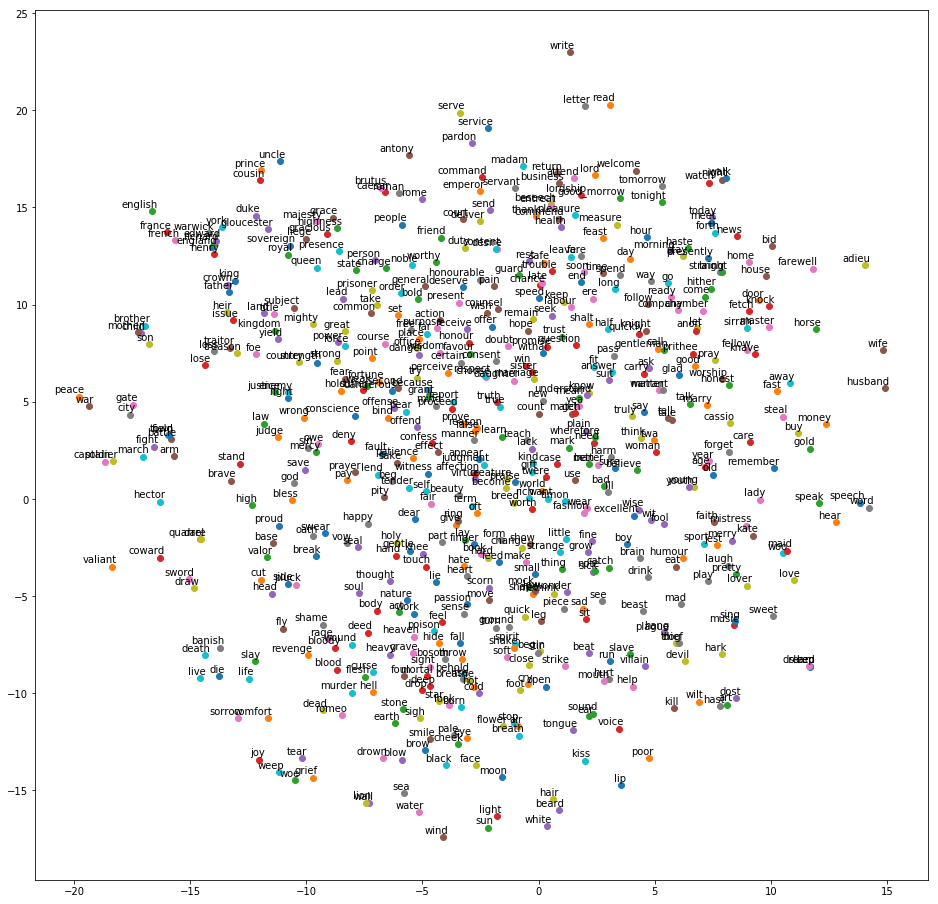

In [107]:
tsnePlot(model)

## VOILA!!

This code was adapted from Kavita Ganesan at [http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.XFnQmc9KjUI](http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.XFnQmc9KjUI). Accessed 02/05/2019. The tsne_plot function was taken entirley from https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne/notebook and was accessed on 02/25/2019.